In [132]:
# Importación de librerías estándar para manejo del sistema y control de warnings
import os
import warnings
import json

# Librerías fundamentales para análisis numérico y manipulación de datos
import numpy as np
import pandas as pd

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Herramientas de scikit-learn utilizadas a lo largo del análisis de clustering
from sklearn.preprocessing import StandardScaler, QuantileTransformer                        # Estandarización de variables
from sklearn.cluster import KMeans                                                           # Algoritmo de clustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score  # Métrica de calidad de clustering
from sklearn.decomposition import PCA                                                        # Reducción de dimensionalidad

# Configuración estética de los gráficos para mantener consistencia visual
sns.set(style="whitegrid")

# Supresión de warnings para evitar ruido visual durante la ejecución del notebook
warnings.filterwarnings("ignore")

# Obtención dinámica de la ruta del notebook para que el proyecto sea portable
NOTEBOOK_DIR = os.getcwd()

# Definición del directorio raíz del proyecto a partir de la ubicación del notebook
PROJECT_ROOT = os.path.dirname(NOTEBOOK_DIR)

# Rutas donde se almacenan los datos procesados y resultados del clustering
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")
CLUSTER_DIR = os.path.join(PROCESSED_DIR, "clustering")

# Carpeta específica para almacenar visualizaciones generadas en el análisis
PLOTS_DIR = os.path.join(CLUSTER_DIR, "plots")

# Creación automática de las carpetas necesarias si no existen
# Esto evita errores en tiempo de ejecución al guardar resultados
os.makedirs(CLUSTER_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)


In [133]:
# Verifica si el DataFrame agregado ya existe en memoria para evitar recargarlo innecesariamente
# Esto hace que la celda sea segura de ejecutar múltiples veces sin alterar el estado del análisis
if 'agg_df' not in globals():
    # Construye la ruta al archivo CSV que contiene las estadísticas agregadas por empresa
    agg_path = os.path.join(PROCESSED_DIR, "tech30_aggregated_stats_2018_2024.csv")

    # Comprueba explícitamente que el archivo exista, asegurando que el pipeline
    # previo de agregación haya sido ejecutado correctamente
    if not os.path.exists(agg_path):
        raise FileNotFoundError(
            f"No se encontró {agg_path}. Ejecuta antes el pipeline que crea agg_df."
        )

    # Carga del dataset agregado en un DataFrame de pandas
    # Este DataFrame contiene las variables resumen que servirán como base
    # para el análisis de clustering entre empresas
    agg_df = pd.read_csv(agg_path)

# Muestra información básica del dataset cargado para confirmar su dimensión
# y contextualizar el análisis posterior
print("agg_df cargado:", agg_df.shape)

# Visualización preliminar de las primeras filas para inspección estructural
agg_df.head()


agg_df cargado: (30, 9)


,Company,Ticker,MeanReturn,Volatility,Beta,AvgVolume,N_months,PC1,PC2
0,ASML,ASML,0.015685,0.096761,1.272729,2.083840e+07,83,-0.004281,-0.337094
1,Accenture,ACN,0.010715,0.072160,0.989995,4.702290e+07,83,-0.941908,0.097634
2,Adobe,ADBE,0.009672,0.095036,1.187009,6.403960e+07,83,-0.403921,-0.295173
3,Alphabet,GOOGL,0.014190,0.072604,0.930717,7.089949e+08,83,-0.723142,0.446013
4,Amazon,AMZN,0.013438,0.089370,1.245651,1.591051e+09,83,0.125163,0.488400


In [134]:
# Obtención de la ruta de datos procesados desde el entorno global si existe;
# en caso contrario, se define una ruta por defecto relativa al directorio actual
PROCESSED_DIR = globals().get(
    'PROCESSED_DIR',
    os.path.join(os.getcwd(), "data", "processed")
)

# Recupera el DataFrame agregado desde memoria si ya fue cargado previamente
agg_df = globals().get('agg_df', None)

# El clustering depende de las estadísticas agregadas, por lo que se exige
# explícitamente que agg_df esté disponible
if agg_df is None:
    raise RuntimeError("agg_df no está en memoria. Ejecuta la CELDA 2 primero.")

# Ruta al archivo con resultados CAPM ya calculados por empresa
capm_path = os.path.join(PROCESSED_DIR, "capm_results_by_company.csv")

# Flag que indica si se puede usar directamente el CSV existente
use_file = False

# Si el archivo existe, se carga y se valida que contenga las columnas mínimas necesarias
# para integrar la beta al dataset agregado
if os.path.exists(capm_path):
    capm = pd.read_csv(capm_path)
    expected = {'Company', 'n_obs', 'beta'}
    if expected.issubset(set(capm.columns)):
        use_file = True
    else:
        # Advertencia informativa: el archivo existe pero no cumple el esquema esperado
        print(f"⚠️ El CSV existe pero faltan columnas esperadas: {expected - set(capm.columns)}")
else:
    # Mensaje informativo indicando que no se encontró el archivo de resultados CAPM
    print("ℹ️ No encontré capm_results_by_company.csv — procederemos a recalcular si es necesario.")

# Si el CSV es válido, se prioriza su uso para mantener consistencia con análisis previos
# y evitar recalcular betas innecesariamente
if use_file:
    print(f"✅ Usando betas desde {capm_path}")

    # Se intenta mapear la beta al DataFrame agregado usando una clave común
    # Se prioriza 'Company' y se deja 'Ticker' como alternativa
    if 'Company' in agg_df.columns:
        agg_df['Beta'] = agg_df['Company'].map(
            capm.set_index('Company')['beta']
        )
    elif 'Ticker' in agg_df.columns and 'Company' in capm.columns:
        # Caso alternativo en el que los identificadores coinciden por ticker
        agg_df['Beta'] = agg_df['Ticker'].map(
            capm.set_index('Company')['beta']
        )
    else:
        # Advertencia si no se encuentra una clave clara para el mapeo
        print("⚠️ Ni 'Company' ni 'Ticker' encontrados para mapear. Crea mapeo manual.")

    # Reporte informativo del número de betas correctamente incorporadas
    valid = agg_df['Beta'].notna().sum()
    print(f"✅ Betas importados: {valid}/{len(agg_df)}")
else:
    # Mensaje informativo en caso de no disponer de un CSV válido
    print("🔄 No hay CSV válido: si quieres puedo recalcular betas ahora (usa la función de recálculo).")

# ----------------------------------------------------------------------------
# Bloque opcional de validación de betas:
# compara las betas importadas con un recálculo directo usando retornos históricos,
# únicamente si los datos necesarios están disponibles en memoria
# ----------------------------------------------------------------------------

# Control explícito para activar o desactivar la validación
validate = True

if validate:
    # Recupera los datos de retornos individuales y del mercado desde el entorno global
    data = globals().get('data', None)
    qqq_data = globals().get('qqq_data', None)

    # Si faltan los datos necesarios, se informa y se omite la validación
    if data is None or qqq_data is None:
        print("ℹ️ No hay 'data' o 'qqq_data' en memoria — no puedo validar con recálculo.")
    else:
        # Función auxiliar para recalcular beta de forma directa
        # utilizando covarianza y varianza poblacional
        def calc_beta_simple(df_emp, df_mkt, min_obs=12):
            re = df_emp['Returns'].dropna()
            rm = df_mkt['Returns'].dropna()
            fechas = re.index.intersection(rm.index)

            # Se exige un número mínimo de observaciones para evitar betas inestables
            if len(fechas) < min_obs:
                return np.nan

            cov = np.cov(re.loc[fechas], rm.loc[fechas], ddof=0)[0, 1]
            var = np.var(rm.loc[fechas], ddof=0)

            return cov / var if var != 0 else np.nan

        # Preparación de los dataframes asegurando que la fecha sea el índice temporal
        d = data.copy()
        if 'Date' in d.columns:
            d['Date'] = pd.to_datetime(d['Date'])

        q = qqq_data.copy()
        if 'Date' in q.columns:
            q['Date'] = pd.to_datetime(q['Date'])

        # Selección de un conjunto de claves comunes para comparar betas
        sample_cmp = []
        keys = []

        if 'Ticker' in d.columns:
            keys = sorted(
                set(d['Ticker'].unique()) &
                set(agg_df.get('Ticker', []).tolist())
            )
        elif 'Company' in agg_df.columns:
            # Alternativa menos robusta si solo se dispone de nombres de empresa
            keys = sorted(set(agg_df['Company'].unique()))

        # Comparación limitada a un subconjunto para mantener eficiencia computacional
        for k in keys[:50]:
            tmp = d[d['Ticker'] == k].set_index('Date')
            try:
                q_idx = q.set_index('Date')
                recalc = calc_beta_simple(tmp, q_idx)
            except Exception:
                recalc = np.nan

            # Beta importada previamente en agg_df
            beta_file = agg_df.loc[
                (agg_df.get('Ticker') == k) | (agg_df.get('Company') == k),
                'Beta'
            ]
            beta_file = beta_file.iloc[0] if len(beta_file) > 0 else np.nan

            sample_cmp.append({
                'key': k,
                'beta_file': beta_file,
                'beta_recalc': recalc,
                'diff': (
                    np.nan
                    if pd.isna(beta_file) or pd.isna(recalc)
                    else abs(beta_file - recalc)
                )
            })

        # Construcción del DataFrame de comparación y ordenación por discrepancia
        cmp_df = pd.DataFrame(sample_cmp).sort_values('diff', ascending=False)

        if cmp_df.empty:
            print("ℹ️ No se encontraron tickers para comparar durante la validación.")
        else:
            # Presentación de las mayores discrepancias para inspección analítica
            print("\nTop 10 discrepancias entre beta_file y beta_recalc (abs diff):")
            display(cmp_df.head(10))

            # Medida robusta de la diferencia típica entre betas
            med_diff = cmp_df['diff'].dropna().median()
            print(f"Mediana de la diferencia absoluta en la muestra: {med_diff:.4f}")

            # Advertencia si se detectan discrepancias relevantes
            big = cmp_df[cmp_df['diff'] > 0.05]
            if not big.empty:
                print(
                    f"⚠️ {len(big)} tickers con diferencia > 0.05. "
                    "Revisa metodología, frecuencia o proxy de mercado utilizada."
                )


ℹ️ No encontré capm_results_by_company.csv — procederemos a recalcular si es necesario.
🔄 No hay CSV válido: si quieres puedo recalcular betas ahora (usa la función de recálculo).
ℹ️ No hay 'data' o 'qqq_data' en memoria — no puedo validar con recálculo.


In [135]:
# Definición explícita de las variables que se utilizarán en el análisis de clustering
# Incluyen medidas de rentabilidad, riesgo, exposición al mercado y tamaño/actividad
req_cols = ["Company", "MeanReturn", "Volatility", "Beta", "AvgVolume"]

# Verificación de que todas las variables requeridas estén presentes en el DataFrame agregado
# Esto garantiza que el clustering se construya sobre un conjunto consistente de features
missing = [c for c in req_cols if c not in agg_df.columns]
if missing:
    raise KeyError(f"Faltan columnas en agg_df: {missing}")

# Selección de las columnas relevantes y eliminación inicial de observaciones incompletas
# Se reinicia el índice para mantener un DataFrame limpio y ordenado
agg = agg_df[req_cols].dropna().reset_index(drop=True).copy()

# Conversión explícita de las variables cuantitativas a tipo numérico
# Esto previene errores silenciosos y asegura compatibilidad con los algoritmos de clustering
for c in ["MeanReturn", "Volatility", "Beta", "AvgVolume"]:
    agg[c] = pd.to_numeric(agg[c], errors="coerce")

# Eliminación final de filas con valores faltantes tras la coerción numérica
# Este paso asegura que todas las observaciones utilizadas sean válidas
agg = agg.dropna(
    subset=["MeanReturn", "Volatility", "Beta", "AvgVolume"]
).reset_index(drop=True)

# Información resumida del dataset final que será utilizado en el clustering
# Permite contextualizar el tamaño muestral del análisis
print("Datos para clustering:", agg.shape)

# Visualización preliminar para inspeccionar la estructura y valores de las variables seleccionadas
agg.head()


Datos para clustering: (30, 5)


,Company,MeanReturn,Volatility,Beta,AvgVolume
0,ASML,0.015685,0.096761,1.272729,2.083840e+07
1,Accenture,0.010715,0.072160,0.989995,4.702290e+07
2,Adobe,0.009672,0.095036,1.187009,6.403960e+07
3,Alphabet,0.014190,0.072604,0.930717,7.089949e+08
4,Amazon,0.013438,0.089370,1.245651,1.591051e+09


In [136]:
"""
Normalización consistente de todas las variables utilizadas en el clustering.

La motivación estadística es asegurar que todas las features contribuyan
de forma equilibrada a las distancias euclídeas utilizadas por K-Means.
Al aplicar StandardScaler a todas las variables se evita que escalas
heterogéneas (por ejemplo volumen vs retornos) dominen el resultado.
"""

# Mensaje informativo que contextualiza el propósito de la celda
print("🔧 CELDA 4 - Normalización uniforme de variables para clustering\n")
print("=" * 80)

# Definición explícita de las variables que formarán la matriz de features
# Estas variables resumen rendimiento, riesgo, exposición sistemática y tamaño
features = ['MeanReturn', 'Volatility', 'Beta', 'AvgVolume']

print(f"📊 Features seleccionados: {features}\n")

# Inspección informativa de valores faltantes antes del preprocesamiento
# Esto permite evaluar la calidad de los datos y justificar la estrategia de imputación
print("🔍 Verificando valores nulos ANTES de normalización:")
print(agg_df[features].isna().sum())
print()

# Copia del DataFrame original para evitar modificar directamente la fuente
# Se opta por una estrategia flexible de imputación para mantener el tamaño muestral
agg_df_clean = agg_df.copy()

# Imputación de valores faltantes usando la mediana de cada variable
# La mediana es robusta frente a outliers y adecuada en contextos financieros
for col in features:
    n_nulos = agg_df_clean[col].isna().sum()
    if n_nulos > 0:
        mediana = agg_df_clean[col].median()
        agg_df_clean[col].fillna(mediana, inplace=True)
        print(f"⚠️ {col}: {n_nulos} valores imputados con mediana ({mediana:.4f})")

print()

# Aplicación de StandardScaler para centrar y escalar todas las variables
# Cada feature queda con media aproximada 0 y desviación estándar aproximada 1
print("🔄 Aplicando StandardScaler a TODAS las variables...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(agg_df_clean[features])

# Conversión a DataFrame para facilitar inspección estadística posterior
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Estadísticos descriptivos tras la normalización
# Se utilizan para comprobar empíricamente el correcto escalado
print("\n📊 Estadísticos DESPUÉS de normalización:")
print(X_scaled_df.describe().round(4))
print()

# Evaluación explícita de la calidad del escalado
# Se comprueba que la media sea cercana a 0 y la desviación cercana a 1
medias = X_scaled_df.mean()
stds = X_scaled_df.std()

print("✅ Verificación de calidad de normalización:")
for feature in features:
    media = medias[feature]
    std = stds[feature]
    ok = abs(media) < 0.01 and 0.95 < std < 1.05
    status = "✓" if ok else "✗"
    print(f"  {status} {feature:15s}: media={media:7.4f}, std={std:6.4f}")

print()

# Almacenamiento de las versiones normalizadas en el DataFrame limpio
# Esto facilita análisis posteriores y trazabilidad de las transformaciones
for i, feature in enumerate(features):
    agg_df_clean[f'{feature}_norm'] = X_scaled[:, i]

print("✅ Variables normalizadas guardadas con sufijo '_norm'")
print(f"✅ Matriz X_scaled lista para clustering: {X_scaled.shape}")
print()

# Exportación de la matriz normalizada para validación externa o reutilización
# Se conserva el índice para mantener correspondencia con las observaciones originales
X_scaled_export = pd.DataFrame(
    X_scaled,
    columns=features,
    index=agg_df_clean.index
)

X_scaled_export.to_csv(
    os.path.join(CLUSTER_DIR, "variables_normalizadas.csv"),
    index=True
)

print("💾 Matriz normalizada exportada: variables_normalizadas.csv")
print()
print("=" * 80)
print("✅ Normalización uniforme aplicada exitosamente")
print("=" * 80)


🔧 CELDA 4 - Normalización uniforme de variables para clustering

📊 Features seleccionados: ['MeanReturn', 'Volatility', 'Beta', 'AvgVolume']

🔍 Verificando valores nulos ANTES de normalización:
MeanReturn    0
Volatility    0
Beta          0
AvgVolume     0
dtype: int64


🔄 Aplicando StandardScaler a TODAS las variables...

📊 Estadísticos DESPUÉS de normalización:
       MeanReturn  Volatility     Beta  AvgVolume
count     30.0000     30.0000  30.0000    30.0000
mean      -0.0000      0.0000  -0.0000     0.0000
std        1.0171      1.0171   1.0171     1.0171
min       -2.1308     -1.1400  -1.7974    -0.4586
25%       -0.4806     -0.6616  -0.6110    -0.4117
50%       -0.1459     -0.2674  -0.2770    -0.3380
75%        0.5503      0.1856   0.3651    -0.0836
max        2.2046      3.5527   2.7275     5.0089

✅ Verificación de calidad de normalización:
  ✓ MeanReturn     : media=-0.0000, std=1.0171
  ✓ Volatility     : media= 0.0000, std=1.0171
  ✓ Beta           : media=-0.0000, std=1.01

🔍 CELDA 5 - Análisis multi-métrica para selección de k

📊 Calculando métricas para k=2 a k=10...

🎯 K ÓPTIMOS POR MÉTRICA:
   Gap Statistic:      k = 4
   Silhouette Score:   k = 2
   Davies-Bouldin:     k = 3



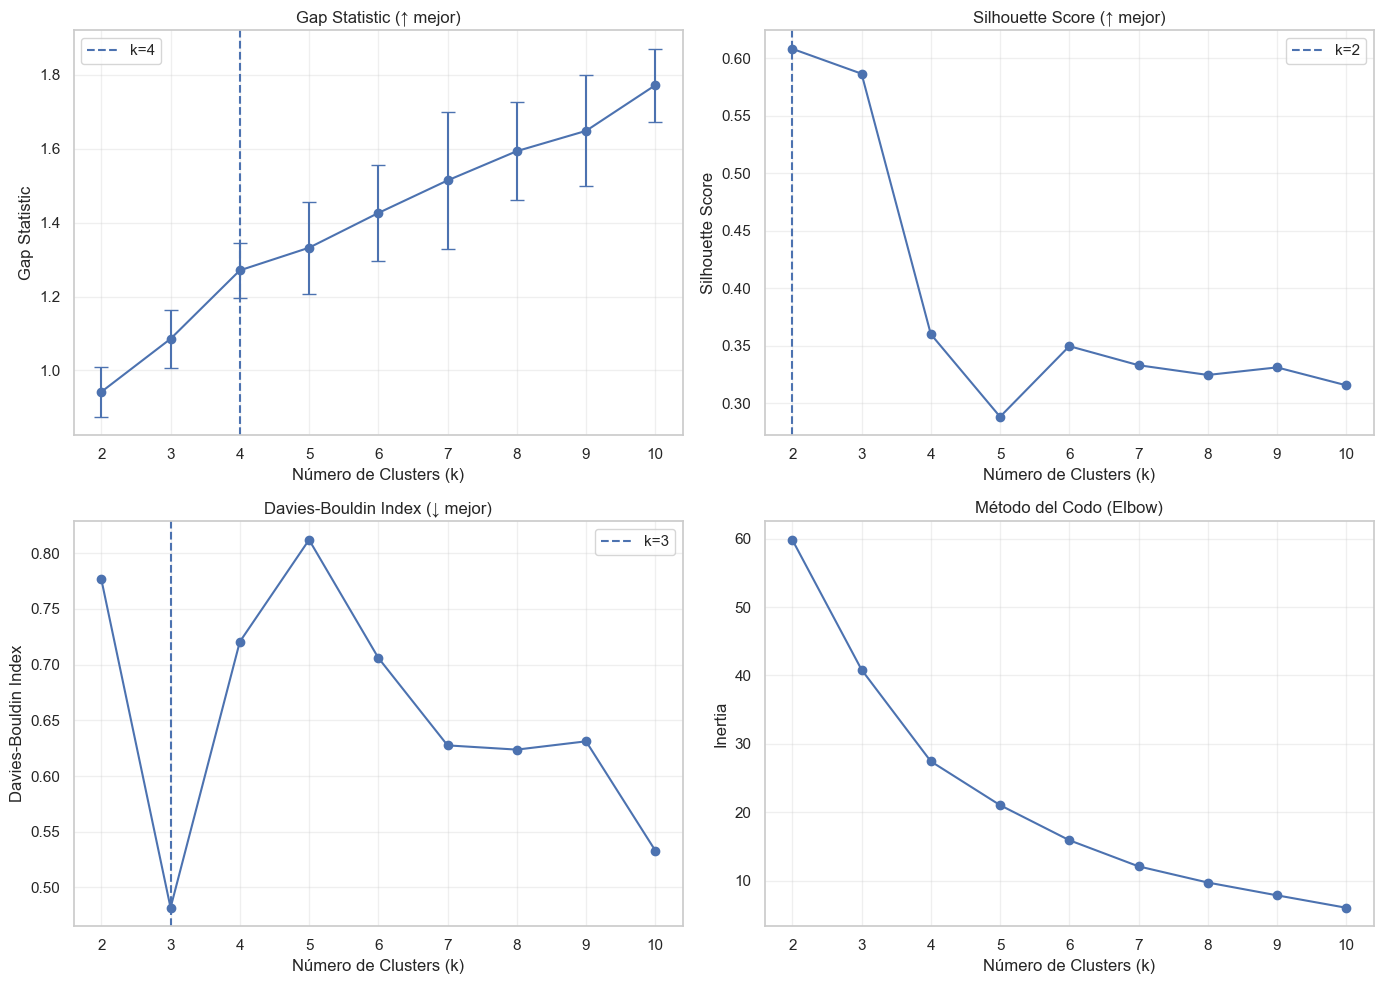


📊 TABLA RESUMEN DE MÉTRICAS POR k:
 k    gap  silhouette  davies_bouldin  inertia
 2 0.9419      0.6083          0.7766  59.8162
 3 1.0855      0.5867          0.4817  40.8429
 4 1.2707      0.3602          0.7205  27.4550
 5 1.3320      0.2884          0.8121  21.0560
 6 1.4260      0.3498          0.7061  15.9343
 7 1.5141      0.3333          0.6275  12.1171
 8 1.5934      0.3248          0.6237   9.7536
 9 1.6483      0.3314          0.6311   7.8828
10 1.7719      0.3158          0.5330   6.0676

⚠️ SIGUIENTE ANÁLISIS: comparación formal de soluciones alternativas de k


In [137]:
"""
Selección del número óptimo de clusters mediante un enfoque multi-métrica.

Se combinan métricas complementarias para evitar depender de un único criterio:
- Gap Statistic: compara la compactación observada frente a datos aleatorios
- Silhouette Score: evalúa cohesión intra-cluster y separación inter-cluster
- Davies-Bouldin Index: mide similitud promedio entre clusters (menor es mejor)

Este enfoque mejora la robustez de la decisión sobre k en contextos financieros,
donde las estructuras no siempre son claramente separables.
"""

# Mensaje informativo que introduce el análisis de selección de k
print("🔍 CELDA 5 - Análisis multi-métrica para selección de k\n")
print("=" * 80)

# Función que implementa el Gap Statistic manteniendo la lógica original
# Compara la inercia del clustering real con la esperada bajo datos de referencia aleatorios
def gap_statistic(X, k_range, n_refs=10):
    """
    Calcula el Gap Statistic para distintos valores de k.

    Devuelve:
    - gaps: diferencia entre la inercia esperada (datos aleatorios) y la observada
    - sk: desviación estándar ajustada del Gap Statistic
    - k_opt: primer k que satisface el criterio de optimalidad de Tibshirani et al.
    """
    gaps = []
    sk = []

    for k in k_range:
        # Ajuste de K-Means sobre los datos reales
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
        labels = kmeans.fit_predict(X)
        W_k = kmeans.inertia_

        # Cálculo de inercias sobre datasets de referencia uniformes
        ref_inertias = []
        for _ in range(n_refs):
            X_ref = np.random.uniform(
                X.min(axis=0),
                X.max(axis=0),
                size=X.shape
            )
            kmeans_ref = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans_ref.fit(X_ref)
            ref_inertias.append(kmeans_ref.inertia_)

        # Cálculo del Gap Statistic y su desviación estándar ajustada
        E_log_W_k = np.mean(np.log(ref_inertias))
        gap = E_log_W_k - np.log(W_k)
        sd_k = np.std(np.log(ref_inertias))
        s_k = sd_k * np.sqrt(1 + 1 / n_refs)

        gaps.append(gap)
        sk.append(s_k)

    # Regla de selección del k óptimo según Gap Statistic
    k_opt = k_range[0]
    for i in range(len(gaps) - 1):
        if gaps[i] >= gaps[i + 1] - sk[i + 1]:
            k_opt = k_range[i]
            break

    return gaps, sk, k_opt


# Rango de valores de k evaluados
k_range = range(2, 11)

# Estructura para almacenar todas las métricas por valor de k
metricas = {
    'k': [],
    'gap': [],
    'silhouette': [],
    'davies_bouldin': [],
    'inertia': []
}

print("📊 Calculando métricas para k=2 a k=10...\n")

# Cálculo del Gap Statistic
gaps, sk, k_opt_gap = gap_statistic(X_scaled, k_range)

# Cálculo de métricas complementarias para cada k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = kmeans.fit_predict(X_scaled)

    metricas['k'].append(k)
    metricas['gap'].append(gaps[k - 2])  # Correspondencia índice-k
    metricas['silhouette'].append(silhouette_score(X_scaled, labels))
    metricas['davies_bouldin'].append(davies_bouldin_score(X_scaled, labels))
    metricas['inertia'].append(kmeans.inertia_)

# Conversión a DataFrame para análisis y visualización
metricas_df = pd.DataFrame(metricas)

# Identificación de los valores óptimos de k según cada métrica
k_opt_silhouette = metricas_df.loc[
    metricas_df['silhouette'].idxmax(), 'k'
]
k_opt_db = metricas_df.loc[
    metricas_df['davies_bouldin'].idxmin(), 'k'
]

# Resumen informativo de los valores óptimos sugeridos por cada criterio
print("🎯 K ÓPTIMOS POR MÉTRICA:")
print(f"   Gap Statistic:      k = {k_opt_gap}")
print(f"   Silhouette Score:   k = {int(k_opt_silhouette)}")
print(f"   Davies-Bouldin:     k = {int(k_opt_db)}")
print()

# Visualización conjunta de todas las métricas para facilitar la comparación
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gap Statistic con barras de error
ax1 = axes[0, 0]
ax1.errorbar(k_range, gaps, yerr=sk, marker='o', capsize=5)
ax1.axvline(k_opt_gap, linestyle='--', label=f'k={k_opt_gap}')
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Gap Statistic')
ax1.set_title('Gap Statistic (↑ mejor)')
ax1.legend()
ax1.grid(alpha=0.3)

# Silhouette Score
ax2 = axes[0, 1]
ax2.plot(k_range, metricas_df['silhouette'], marker='o')
ax2.axvline(k_opt_silhouette, linestyle='--', label=f'k={int(k_opt_silhouette)}')
ax2.set_xlabel('Número de Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score (↑ mejor)')
ax2.legend()
ax2.grid(alpha=0.3)

# Davies-Bouldin Index
ax3 = axes[1, 0]
ax3.plot(k_range, metricas_df['davies_bouldin'], marker='o')
ax3.axvline(k_opt_db, linestyle='--', label=f'k={int(k_opt_db)}')
ax3.set_xlabel('Número de Clusters (k)')
ax3.set_ylabel('Davies-Bouldin Index')
ax3.set_title('Davies-Bouldin Index (↓ mejor)')
ax3.legend()
ax3.grid(alpha=0.3)

# Inercia (Elbow Method) como referencia adicional
ax4 = axes[1, 1]
ax4.plot(k_range, metricas_df['inertia'], marker='o')
ax4.set_xlabel('Número de Clusters (k)')
ax4.set_ylabel('Inertia')
ax4.set_title('Método del Codo (Elbow)')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    os.path.join(PLOTS_DIR, "seleccion_k_multimetrica.png"),
    dpi=300
)
plt.show()

# Presentación tabular completa de las métricas por k
print("\n📊 TABLA RESUMEN DE MÉTRICAS POR k:")
print(metricas_df.to_string(index=False, float_format='%.4f'))
print()

print("=" * 80)
print("⚠️ SIGUIENTE ANÁLISIS: comparación formal de soluciones alternativas de k")
print("=" * 80)


In [138]:
"""
Comparación formal entre dos soluciones candidatas de clustering (k=2 y k=9)
y toma de decisión final basada en métricas cuantitativas y criterios teóricos.

El objetivo es balancear:
- Parsimonia e interpretabilidad (k pequeño)
- Capacidad de segmentación y detalle (k grande)

Se evalúan ambas soluciones con métricas estándar y se justifica
explícitamente la elección final.
"""

# Mensaje informativo que introduce la comparación formal entre soluciones
print("⚖️ CELDA 5.5 - COMPARACIÓN FORMAL: k=2 vs k=9\n")
print("=" * 80)

# Función auxiliar que ajusta un modelo K-Means y calcula un conjunto completo
# de métricas de calidad para un valor dado de k
def evaluar_clustering_completo(X, k, mostrar_distribucion=True):
    """
    Ajusta un modelo K-Means y evalúa su calidad mediante múltiples métricas.

    Retorna un diccionario con:
    - Métricas de validación interna
    - Modelo entrenado
    - Etiquetas de cluster
    - Distribución de observaciones por cluster (opcional)
    """
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
    labels = kmeans.fit_predict(X)

    metricas = {
        'k': k,
        'silhouette': silhouette_score(X, labels),
        'calinski_harabasz': calinski_harabasz_score(X, labels),
        'davies_bouldin': davies_bouldin_score(X, labels),
        'inertia': kmeans.inertia_,
        'modelo': kmeans,
        'labels': labels
    }

    # Distribución de empresas por cluster para evaluar balance y posibles clusters pequeños
    if mostrar_distribucion:
        unique, counts = np.unique(labels, return_counts=True)
        metricas['distribucion'] = dict(zip(unique, counts))

    return metricas


# Evaluación explícita de ambas soluciones candidatas
print("🔄 Evaluando k=2 y k=9 con métricas completas...\n")

resultados_k2 = evaluar_clustering_completo(X_scaled, k=2)
resultados_k9 = evaluar_clustering_completo(X_scaled, k=9)

# Construcción de una tabla comparativa con las métricas principales
# para facilitar una comparación directa entre ambas soluciones
comparacion = pd.DataFrame([
    {
        'k': resultados_k2['k'],
        'Silhouette (↑)': resultados_k2['silhouette'],
        'Calinski-H (↑)': resultados_k2['calinski_harabasz'],
        'Davies-B (↓)': resultados_k2['davies_bouldin'],
        'Inertia': resultados_k2['inertia']
    },
    {
        'k': resultados_k9['k'],
        'Silhouette (↑)': resultados_k9['silhouette'],
        'Calinski-H (↑)': resultados_k9['calinski_harabasz'],
        'Davies-B (↓)': resultados_k9['davies_bouldin'],
        'Inertia': resultados_k9['inertia']
    }
])

# Presentación de la tabla comparativa de métricas
print("📊 TABLA COMPARATIVA:")
print(comparacion.to_string(index=False, float_format='%.4f'))
print()

# Análisis descriptivo de la distribución de empresas por cluster
# Esto permite detectar posibles clusters muy pequeños o desequilibrados
print("📈 DISTRIBUCIÓN DE EMPRESAS POR CLUSTER:")

print("\n  k=2:")
for cluster, count in resultados_k2['distribucion'].items():
    pct = (count / len(X_scaled)) * 100
    print(f"    Cluster {cluster}: {count:2d} empresas ({pct:5.1f}%)")

print("\n  k=9:")
for cluster, count in resultados_k9['distribucion'].items():
    pct = (count / len(X_scaled)) * 100
    print(f"    Cluster {cluster}: {count:2d} empresas ({pct:5.1f}%)")

print()

# Análisis cualitativo de ventajas y desventajas de cada solución
# Este bloque documenta la interpretación económica y metodológica
print("⚖️ ANÁLISIS COMPARATIVO:\n")

print("📘 k=2 (PARSIMONIA):")
print("   - Interpretación simple y robusta")
print("   - Menor riesgo de sobreajuste")
print("   - Adecuado para comunicación y análisis agregado")
print("   - Puede ocultar heterogeneidad interna")

print("\n📗 k=9 (GRANULARIDAD):")
print("   - Mayor nivel de detalle en la segmentación")
print("   - Identificación de subgrupos específicos")
print("   - Mayor complejidad interpretativa")
print("   - Riesgo de clusters pequeños y ruido")

print()

# Sistema explícito de puntuación para tomar una decisión reproducible
# Se asignan puntos según el desempeño relativo en cada métrica
print("🎯 CRITERIO DE DECISIÓN AUTOMÁTICO:\n")

puntos_k2 = 0
puntos_k9 = 0

# Silhouette Score: se exige una diferencia mínima para considerar ventaja clara
if resultados_k2['silhouette'] > resultados_k9['silhouette'] + 0.05:
    puntos_k2 += 1
    print("   ✓ Silhouette favorece k=2")
elif resultados_k9['silhouette'] > resultados_k2['silhouette'] + 0.05:
    puntos_k9 += 1
    print("   ✓ Silhouette favorece k=9")
else:
    print("   ≈ Silhouette: empate técnico")

# Davies-Bouldin Index: menor valor indica clusters mejor separados
if resultados_k2['davies_bouldin'] < resultados_k9['davies_bouldin']:
    puntos_k2 += 1
    print("   ✓ Davies-Bouldin favorece k=2")
else:
    puntos_k9 += 1
    print("   ✓ Davies-Bouldin favorece k=9")

# Calinski-Harabasz: mayor valor implica mejor relación entre dispersión inter e intra cluster
if resultados_k2['calinski_harabasz'] > resultados_k9['calinski_harabasz']:
    puntos_k2 += 1
    print("   ✓ Calinski-Harabasz favorece k=2")
else:
    puntos_k9 += 1
    print("   ✓ Calinski-Harabasz favorece k=9")

# Bonus explícito por simplicidad e interpretabilidad
puntos_k2 += 1
print("   ✓ Principio de parsimonia favorece k=2")

print()

# Decisión final basada en la puntuación total
if puntos_k2 >= puntos_k9:
    k_final = 2
    razon = f"Parsimonia + mejor balance métrico (puntos: {puntos_k2} vs {puntos_k9})"
    modelo_final = resultados_k2['modelo']
    labels_finales = resultados_k2['labels']
else:
    k_final = 9
    razon = f"Mayor granularidad con métricas superiores (puntos: {puntos_k9} vs {puntos_k2})"
    modelo_final = resultados_k9['modelo']
    labels_finales = resultados_k9['labels']

print("=" * 80)
print(f"✅ DECISIÓN FINAL: k = {k_final}")
print(f"   Justificación: {razon}")
print("=" * 80)
print()

# Almacenamiento del resultado final de clustering en el DataFrame limpio
# Esto permite su uso directo en análisis posteriores e interpretación económica
agg_df_clean['Cluster'] = labels_finales

print("💾 Clustering final guardado en agg_df_clean['Cluster']")
print(f"✅ Modelo K-Means con k={k_final} listo para análisis posteriores")
print()

# Exportación de la decisión y métricas clave a un archivo JSON
# Facilita trazabilidad y documentación del proceso de decisión
decision_clustering = {
    'k_seleccionado': k_final,
    'justificacion': razon,
    'metricas_k2': {
        k: v for k, v in resultados_k2.items()
        if k not in ['modelo', 'labels', 'distribucion']
    },
    'metricas_k9': {
        k: v for k, v in resultados_k9.items()
        if k not in ['modelo', 'labels', 'distribucion']
    }
}

import json
with open(os.path.join(CLUSTER_DIR, 'decision_clustering.json'), 'w') as f:
    json.dump(decision_clustering, f, indent=2)

print("📄 Decisión exportada: decision_clustering.json")
print()
print("=" * 80)
print("✅ COMPARACIÓN Y DECISIÓN DE CLUSTERING COMPLETADAS")
print("=" * 80)


⚖️ CELDA 5.5 - COMPARACIÓN FORMAL: k=2 vs k=9

🔄 Evaluando k=2 y k=9 con métricas completas...

📊 TABLA COMPARATIVA:
 k  Silhouette (↑)  Calinski-H (↑)  Davies-B (↓)  Inertia
 2          0.6083         28.1721        0.7766  59.8162
 9          0.3314         37.3353        0.6311   7.8828

📈 DISTRIBUCIÓN DE EMPRESAS POR CLUSTER:

  k=2:
    Cluster 0: 26 empresas ( 86.7%)
    Cluster 1:  4 empresas ( 13.3%)

  k=9:
    Cluster 0:  2 empresas (  6.7%)
    Cluster 1:  6 empresas ( 20.0%)
    Cluster 2:  7 empresas ( 23.3%)
    Cluster 3:  1 empresas (  3.3%)
    Cluster 4:  1 empresas (  3.3%)
    Cluster 5:  2 empresas (  6.7%)
    Cluster 6:  5 empresas ( 16.7%)
    Cluster 7:  2 empresas (  6.7%)
    Cluster 8:  4 empresas ( 13.3%)

⚖️ ANÁLISIS COMPARATIVO:

📘 k=2 (PARSIMONIA):
   - Interpretación simple y robusta
   - Menor riesgo de sobreajuste
   - Adecuado para comunicación y análisis agregado
   - Puede ocultar heterogeneidad interna

📗 k=9 (GRANULARIDAD):
   - Mayor nivel de de

In [139]:
"""
OBJETIVO:
- Ajustar el modelo KMeans final con el k seleccionado formalmente
- Validar estadísticamente los clusters mediante ANOVA
- Construir perfiles interpretables de cada cluster
"""
from scipy.stats import f_oneway

print("🔹 Ajuste final de KMeans y validación estadística\n")
print("="*80)

# -------------------------------------------------------------------------
# Ajuste final del modelo KMeans
# -------------------------------------------------------------------------
# Se utiliza el valor k_final previamente decidido de forma justificada
# (Gap Statistic + comparación multi-métrica).
# n_init alto garantiza estabilidad de la solución.
kmeans = KMeans(
    n_clusters=k_final,
    random_state=42,
    n_init=100
)

# Asignación definitiva de cada empresa a un cluster
# Se usa X_scaled para asegurar coherencia con el espacio normalizado
agg_df_clean["Cluster"] = kmeans.fit_predict(X_scaled)

print(f"✅ KMeans ajustado con k = {k_final}")
print()

# -------------------------------------------------------------------------
# Validación estadística de clusters mediante ANOVA
# -------------------------------------------------------------------------
# Objetivo:
# Verificar si las medias de cada variable difieren significativamente
# entre clusters → evidencia estadística de segmentación real.
anova_results = {}

print("📊 VALIDACIÓN ANOVA (diferencias entre clusters):\n")

for var in features:
    # Extraer los valores de la variable para cada cluster
    # Cada elemento de 'grupos' corresponde a un cluster distinto
    grupos = [
        agg_df_clean[agg_df_clean["Cluster"] == c][var].values
        for c in sorted(agg_df_clean["Cluster"].unique())
    ]
    
    # ANOVA de un factor: contrasta igualdad de medias entre clusters
    f_stat, p_val = f_oneway(*grupos)
    
    # Almacenar estadísticos para reporte posterior
    anova_results[var] = {
        "F_statistic": f_stat,
        "p_value": p_val
    }
    
    # Interpretación inmediata:
    # p < 0.05 → diferencias estadísticamente significativas entre clusters
    print(f"{'✅' if p_val < 0.05 else '⚠️'} {var:15s} | p-value = {p_val:.4f}")

print()

# Guardar resultados ANOVA para trazabilidad y uso en el informe
pd.DataFrame(anova_results).T.to_csv(
    os.path.join(CLUSTER_DIR, "cluster_validation_anova.csv")
)

print("💾 Resultados ANOVA guardados: cluster_validation_anova.csv")
print()

# -------------------------------------------------------------------------
# Construcción de perfiles interpretables de clusters
# -------------------------------------------------------------------------
# Objetivo:
# Traducir los clusters numéricos en perfiles económicos comprensibles.
cluster_profiles = []

for c in sorted(agg_df_clean["Cluster"].unique()):
    # Subconjunto de empresas pertenecientes al cluster c
    sub = agg_df_clean[agg_df_clean["Cluster"] == c]
    
    cluster_profiles.append({
        # Identificador del cluster
        "Cluster": c,
        
        # Tamaño del cluster (número de empresas)
        "N_empresas": len(sub),
        
        # Métricas económicas promedio del cluster
        "Retorno_Mensual_Prom": round(sub["MeanReturn"].mean(), 4),
        "Volatilidad_Mensual_Prom": round(sub["Volatility"].mean(), 4),
        "Beta_Prom": round(sub["Beta"].mean(), 2),
        
        # Empresas más representativas por liquidez
        "Empresas_Top3_Volumen": ", ".join(
            sub.nlargest(3, "AvgVolume")["Ticker"].values
        )
    })

# DataFrame final de perfiles
profiles_df = pd.DataFrame(cluster_profiles)

# Exportar perfiles para análisis cualitativo y reporte final
profiles_df.to_csv(
    os.path.join(CLUSTER_DIR, "cluster_profiles.csv"),
    index=False
)

print("📊 PERFILES DE CLUSTERS:\n")
print(profiles_df.to_string(index=False))
print()

print("="*80)
print("✅ Clustering validado y perfiles construidos")
print("="*80)


🔹 Ajuste final de KMeans y validación estadística

✅ KMeans ajustado con k = 2

📊 VALIDACIÓN ANOVA (diferencias entre clusters):

✅ MeanReturn      | p-value = 0.0000
✅ Volatility      | p-value = 0.0000
✅ Beta            | p-value = 0.0000
✅ AvgVolume       | p-value = 0.0010

💾 Resultados ANOVA guardados: cluster_validation_anova.csv

📊 PERFILES DE CLUSTERS:

 Cluster  N_empresas  Retorno_Mensual_Prom  Volatilidad_Mensual_Prom  Beta_Prom Empresas_Top3_Volumen
       0          26                0.0123                    0.0920       0.98      AAPL, AMZN, NFLX
       1           4                0.0353                    0.1904       1.81      NVDA, TSLA, PLTR

✅ Clustering validado y perfiles construidos


In [140]:
"""
OBJETIVO:
- Evaluar la calidad global del clustering obtenido
- Medir cohesión interna y separación entre clusters
- Proporcionar una interpretación automática de los resultados
"""

# Extraer etiquetas finales de cluster
labels = agg_df_clean["Cluster"].values

# Verificar que el clustering tenga al menos dos grupos distintos
if len(set(labels)) > 1:
    
    # Silhouette Score:
    # Mide qué tan bien cada observación está asignada a su cluster
    # Rango [-1, 1]; valores altos indican clusters compactos y bien separados
    silhouette = silhouette_score(X_scaled, labels)
    
    # Calinski-Harabasz Index:
    # Relación entre varianza inter-cluster e intra-cluster
    # Valores mayores indican mejor separación entre grupos
    calinski = calinski_harabasz_score(X_scaled, labels)

    print("\n📈 MÉTRICAS DE CALIDAD DEL CLUSTERING")
    print(f"  Silhouette Score: {silhouette:.3f} (rango [-1,1], óptimo ~0.5–0.7)")
    print(f"  Calinski-Harabasz: {calinski:.1f} (mayor = mejor separación)")

    # Interpretación automática basada en umbrales habituales
    if silhouette < 0.3:
        print("  ⚠️ ADVERTENCIA: Clusters poco definidos (baja cohesión/separación)")
    elif silhouette > 0.7:
        print("  ✅ EXCELENTE: Clusters muy bien definidos")
    else:
        print("  ✓ ACEPTABLE: Estructura de clusters razonable")
        
else:
    # Caso límite: no se pueden calcular métricas si solo hay un cluster
    print("No hay suficientes clusters distintos para calcular métricas (se requieren ≥ 2).")



📈 MÉTRICAS DE CALIDAD DEL CLUSTERING
  Silhouette Score: 0.608 (rango [-1,1], óptimo ~0.5–0.7)
  Calinski-Harabasz: 28.2 (mayor = mejor separación)
  ✓ ACEPTABLE: Estructura de clusters razonable


In [141]:
# Agrupa las observaciones por cluster asignado y resume las variables clave
# El objetivo es describir estadísticamente cada cluster en términos de:
# - nivel medio (mean)
# - dispersión interna (std)
# - tamaño muestral (count)
cluster_summary = agg_df_clean.groupby("Cluster")[
    ["MeanReturn", "Volatility", "Beta", "AvgVolume"]
].agg(["mean", "std", "count"])

# Exporta el resumen para su uso en el informe y validación externa
# Este archivo permite comparar clusters de forma cuantitativa y reproducible
cluster_summary.to_csv(
    os.path.join(CLUSTER_DIR, "cluster_summary_stats.csv")
)

# Mensaje informativo confirmando el guardado correcto
print("Resumen por cluster guardado.")

# Muestra la tabla resumen para inspección directa en el notebook
cluster_summary


Resumen por cluster guardado.


MeanReturn                 Volatility                      Beta  \
              mean       std count       mean       std count      mean   
Cluster                                                                   
0         0.012310  0.009266    26   0.092039  0.019162    26  0.979571   
1         0.035337  0.005505     4   0.190358  0.044206     4  1.811993   

                            AvgVolume                      
              std count          mean           std count  
Cluster                                                    
0        0.260919    26  4.329866e+08  5.344310e+08    26  
1        0.344115     4  3.400311e+09  4.316903e+09     4

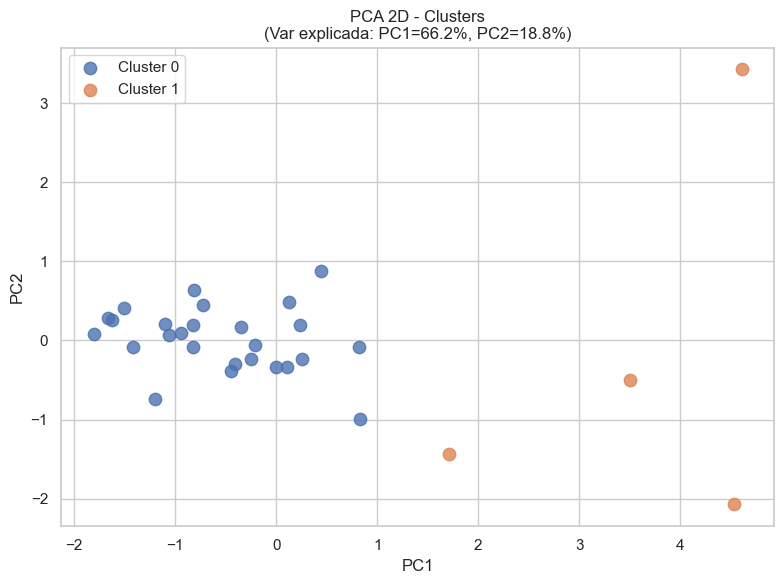

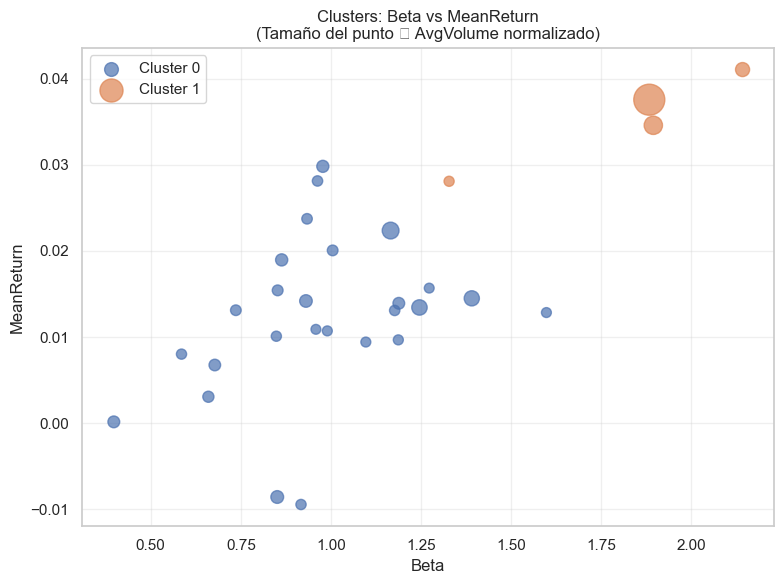

In [142]:
# Reducción de dimensionalidad con PCA para visualización en 2D
# PCA se utiliza aquí únicamente con fines exploratorios e interpretativos,
# no para entrenar el modelo de clustering.
pca = PCA(n_components=2, random_state=42)

# Proyección de los datos normalizados al espacio de los dos primeros componentes
pc = pca.fit_transform(X_scaled)

# Guardar las componentes principales en el DataFrame para facilitar el plotting
agg_df["PC1"] = pc[:, 0]
agg_df["PC2"] = pc[:, 1]

# Proporción de varianza explicada por cada componente principal
# Permite evaluar cuánta información del espacio original se conserva en 2D
var_explained = pca.explained_variance_ratio_

# Gráfico PCA 2D coloreado por cluster
plt.figure(figsize=(8, 6))

# Se dibuja cada cluster por separado para mantener claridad visual
for c in sorted(agg_df_clean["Cluster"].unique()):
    sub = agg_df_clean[agg_df_clean["Cluster"] == c]
    plt.scatter(
        sub["PC1"],
        sub["PC2"],
        label=f"Cluster {c}",
        s=80,
        alpha=0.8
    )


# Etiquetas de ejes correspondientes a las componentes principales
plt.xlabel("PC1")
plt.ylabel("PC2")

# El título incluye la varianza explicada, clave para justificar la proyección
plt.title(
    f"PCA 2D - Clusters\n"
    f"(Var explicada: PC1={var_explained[0]:.1%}, PC2={var_explained[1]:.1%})"
)

plt.legend()
plt.tight_layout()

# Guardar figura para su inclusión directa en el informe
plt.savefig(os.path.join(PLOTS_DIR, "pca_clusters.png"), dpi=150)
plt.show()


# Gráfico de dispersión Beta vs MeanReturn para interpretación económica directa
plt.figure(figsize=(8, 6))

# Se obtienen los valores extremos de volumen para normalizar tamaños de puntos
# Esto evita que outliers dominen visualmente el gráfico
min_vol = agg_df["AvgVolume"].min()
max_vol = agg_df["AvgVolume"].max()

# Representación por cluster para mantener consistencia con el análisis previo
for c in sorted(agg_df_clean["Cluster"].unique()):
    sub = agg_df_clean[agg_df_clean["Cluster"] == c]
    
    # Normalización lineal del volumen al rango [50, 500]
    # El tamaño del punto actúa como proxy visual de liquidez
    normalized_sizes = (
        (sub["AvgVolume"] - min_vol) / (max_vol - min_vol)
    ) * 450 + 50
    
    plt.scatter(
        sub["Beta"],
        sub["MeanReturn"],
        s=normalized_sizes,
        alpha=0.7,
        label=f"Cluster {c}"
    )

# Etiquetas con interpretación financiera directa
plt.xlabel("Beta")
plt.ylabel("MeanReturn")

# El subtítulo aclara explícitamente el significado del tamaño del punto
plt.title(
    "Clusters: Beta vs MeanReturn\n"
    "(Tamaño del punto ∝ AvgVolume normalizado)"
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Guardar figura para documentación y reproducibilidad
plt.savefig(
    os.path.join(PLOTS_DIR, "beta_vs_meanreturn_clusters.png"),
    dpi=150
)
plt.show()


In [143]:
# Encabezado visual para separar claramente la sección interpretativa
print("="*80)
print("INTERPRETACIÓN ECONÓMICA DE CLUSTERS")
print("="*80)

# Iteración sobre cada cluster generado por KMeans
# El objetivo es traducir métricas estadísticas en perfiles económicos interpretables
for c in sorted(agg_df_clean["Cluster"].unique()):
    
    # Subconjunto de empresas pertenecientes al cluster actual
    # .copy() evita warnings y permite cálculos seguros
    sub = agg_df_clean[agg_df_clean["Cluster"] == c].copy()
      
    # Número de empresas en el cluster (tamaño del grupo)
    n = len(sub)
    if n == 0:
        continue

    # Métricas promedio que definen el perfil económico del cluster
    beta_mean = sub['Beta'].mean()           # Riesgo sistemático (CAPM)
    vol_mean = sub['Volatility'].mean()      # Riesgo total (variabilidad de retornos)
    ret_mean = sub['MeanReturn'].mean()      # Rentabilidad media mensual
    vol_med = sub['AvgVolume'].mean()        # Liquidez promedio (proxy de negociabilidad)

    # Identificación del cluster y su tamaño
    print(f"\n📊 CLUSTER {c} ({n} empresas)")
    
    # Interpretación del perfil de riesgo
    print(f"  Perfil de Riesgo:")
    print(
        f"    - Beta promedio: {beta_mean:.2f} "
        f"({'Alto' if beta_mean > 1.2 else 'Bajo' if beta_mean < 0.8 else 'Moderado'} riesgo)"
    )
    
    # Volatilidad media como medida de riesgo total
    print(f"    - Volatilidad mensual (promedio): {vol_mean:.4f}")

    # Interpretación del perfil de rentabilidad
    print(f"  Perfil de Rentabilidad:")
    print(f"    - Retorno mensual (promedio): {ret_mean:.4f}")

    # Interpretación de liquidez usando volumen promedio
    print(f"  Liquidez:")
    print(f"    - Volumen promedio: ${vol_med/1e9:.2f}B")

    # Selección de empresas representativas dentro del cluster
    # Se eligen las tres con mayor volumen, como referentes de liquidez
    top3 = ', '.join(
        sub.sort_values('AvgVolume', ascending=False)
           .head(3)['Ticker']
           .fillna('N/A')
           .values
    )
    print(f"  Empresas (top por volumen): {top3}")

    # Regla heurística simple para clasificación del perfil de inversión
    # No pretende ser una recomendación financiera real, sino una lectura académica
    print(f"  Recomendación: ", end="")
    if (ret_mean > 0) and (beta_mean < 1.0):
        print("✅ Perfil conservador – Bajo riesgo / rendimiento estable")
    elif (ret_mean > vol_mean) and (beta_mean > 1.2):
        print("🚀 Perfil agresivo – Alto potencial / alto riesgo")
    else:
        print("⚖️ Perfil balanceado – Riesgo y rentabilidad moderados")


INTERPRETACIÓN ECONÓMICA DE CLUSTERS

📊 CLUSTER 0 (26 empresas)
  Perfil de Riesgo:
    - Beta promedio: 0.98 (Moderado riesgo)
    - Volatilidad mensual (promedio): 0.0920
  Perfil de Rentabilidad:
    - Retorno mensual (promedio): 0.0123
  Liquidez:
    - Volumen promedio: $0.43B
  Empresas (top por volumen): AAPL, AMZN, NFLX
  Recomendación: ✅ Perfil conservador – Bajo riesgo / rendimiento estable

📊 CLUSTER 1 (4 empresas)
  Perfil de Riesgo:
    - Beta promedio: 1.81 (Alto riesgo)
    - Volatilidad mensual (promedio): 0.1904
  Perfil de Rentabilidad:
    - Retorno mensual (promedio): 0.0353
  Liquidez:
    - Volumen promedio: $3.40B
  Empresas (top por volumen): NVDA, TSLA, PLTR
  Recomendación: ⚖️ Perfil balanceado – Riesgo y rentabilidad moderados


In [144]:
# zscore se utiliza para estandarizar variables dentro de cada cluster
# Permite identificar observaciones extremas relativas a su propio grupo
from scipy.stats import zscore

# Encabezado informativo para la sección de detección de valores atípicos
print("\n🔍 DETECCIÓN DE OUTLIERS POR CLUSTER (z-score dentro del cluster)")

# La detección se realiza de forma independiente para cada cluster
# Esto evita confundir valores extremos globales con características propias del grupo
for c in sorted(agg_df_clean["Cluster"].unique()):
    
    # Subconjunto de empresas pertenecientes al cluster actual
    sub = agg_df_clean[agg_df_clean["Cluster"] == c].copy()
    
    # Umbral mínimo de tamaño para que el z-score sea estadísticamente estable
    if len(sub) < 5:
        print(
            f"\n  Cluster {c}: muy pocas observaciones ({len(sub)}), "
            "se omite detección robusta."
        )
        continue

    # Cálculo de z-scores absolutos dentro del cluster
    # Se analizan tres dimensiones clave:
    # - Beta: riesgo sistemático
    # - MeanReturn: rentabilidad
    # - AvgVolume: liquidez
    sub['z_beta'] = np.abs(zscore(sub['Beta']))
    sub['z_return'] = np.abs(zscore(sub['MeanReturn']))
    sub['z_vol'] = np.abs(zscore(sub['AvgVolume']))

    # Identificación de outliers si alguna dimensión supera el umbral |z| > 2
    # Este criterio es estándar para detectar observaciones atípicas moderadas
    outliers = sub[
        (sub['z_beta'] > 2) |
        (sub['z_return'] > 2) |
        (sub['z_vol'] > 2)
    ]

    # Reporte de resultados para el cluster actual
    if len(outliers) > 0:
        print(f"\n  Cluster {c} - Outliers detectados ({len(outliers)}):")
        
        # Se listan individualmente para facilitar inspección cualitativa
        for _, row in outliers.iterrows():
            print(
                f"    - {row['Ticker']}: "
                f"Beta={row['Beta']:.2f}, "
                f"Return_mensual={row['MeanReturn']:.4f}, "
                f"AvgVolume={row['AvgVolume']:.0f}"
            )
    else:
        # Caso en el que no se detectan valores atípicos relevantes
        print(f"\n  Cluster {c}: Sin outliers significativos (z<=2).")



🔍 DETECCIÓN DE OUTLIERS POR CLUSTER (z-score dentro del cluster)

  Cluster 0 - Outliers detectados (7):
    - AMZN: Beta=1.25, Return_mensual=0.0134, AvgVolume=1591051492
    - AAPL: Beta=1.17, Return_mensual=0.0224, AvgVolume=2092424710
    - INTC: Beta=0.85, Return_mensual=-0.0086, AvgVolume=758620795
    - NFLX: Beta=1.39, Return_mensual=0.0145, AvgVolume=1517224699
    - SNOW: Beta=0.92, Return_mensual=-0.0095, AvgVolume=115646863
    - SPOT: Beta=1.60, Return_mensual=0.0128, AvgVolume=38192011
    - 0700.HK: Beta=0.40, Return_mensual=0.0001, AvgVolume=494464799

  Cluster 1: muy pocas observaciones (4), se omite detección robusta.


In [145]:
# CELDA 13 — Guardar outputs finales
agg_df.to_csv(os.path.join(CLUSTER_DIR, "agg_with_clusters_full.csv"), index=False)

# Guardar summary legible para LaTeX / informe
cluster_summary_reset = cluster_summary.reset_index()
cluster_summary_reset.to_csv(os.path.join(CLUSTER_DIR, "cluster_summary_for_report.csv"), index=False)

# Guardar simple mapping company->cluster
pd.DataFrame({"Company": agg_df_clean["Company"], "Cluster": agg_df_clean["Cluster"]}).to_csv(
    os.path.join(CLUSTER_DIR, "company_cluster_map.csv"), index=False
)

print("✅ Todos los archivos de clustering guardados en:", CLUSTER_DIR)


✅ Todos los archivos de clustering guardados en: d:\Projects\University-Projects\AlphaTech-Analyzer\data\processed\clustering
